# Energy Production 6-Step Ahead Forecasting

This notebook demonstrates a complete pipeline for forecasting energy production 6 hours ahead using a multi-output regression approach. The process includes:

- 6-step ahead forecasting: The model predicts the next 6 hours of energy production for any given time, e.g., if run at 8am, it forecasts 9am–2pm.
- Model and features:
  - Uses XGBoost, a robust machine learning algorithm for tabular data.
  - Features include hour, day of week, month, lagged values, and rolling means of the energy production column (`power_x`), which are effective for time series forecasting.
- Code and process transparency:
  - All steps are shown: data loading, feature engineering, target creation, train/test split, model training, evaluation, and saving.
  - The code is modular, with clear function definitions and comments explaining the reasoning behind each step.
  - Diagnostic print statements are included to make the process transparent and reproducible.
- Forecasting ability:
  - The function `forecast_next_6_hours` allows forecasting the next 6 hours for any input, fulfilling the requirement to forecast a site’s energy potential.

This approach is designed to be clear, reproducible, and easy to adapt for similar forecasting tasks.

---

# Energy Data Exploration

This notebook loads the energy dataset and visualizes energy production patterns over time.

In [6]:
import pandas as pd

df = pd.read_csv(r"C:/Users/prese/Downloads/Recruitment Dataset (1).csv", parse_dates=['date'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              2519 non-null   datetime64[ns]
 1   temperature_2m                    2519 non-null   float64       
 2   relative_humidity_2m              2519 non-null   float64       
 3   apparent_temperature              2519 non-null   float64       
 4   precipitation                     2519 non-null   float64       
 5   rain                              2519 non-null   float64       
 6   cloud_cover                       2519 non-null   float64       
 7   cloud_cover_low                   2519 non-null   float64       
 8   cloud_cover_mid                   2519 non-null   float64       
 9   cloud_cover_high                  2519 non-null   float64       
 10  wind_speed_10m                    2519 non-null 

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,...,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,direct_normal_irradiance_instant,power_x
0,2017-01-01 02:00:00,19.130999,34.823170,15.252626,0.0,0.0,0.0,0.0,0.0,0.0,...,8.099383,131.308520,122.905240,NaN,0.0,0.0,0.0,0.00000,0.000000,1931.490945
1,2017-01-01 03:00:00,19.181000,32.453570,15.554827,0.0,0.0,0.0,0.0,0.0,0.0,...,7.379024,125.909810,116.564990,NaN,0.0,0.0,0.0,0.00000,0.000000,1847.392640
2,2017-01-01 04:00:00,18.681000,33.363396,15.538769,0.0,0.0,0.0,0.0,0.0,0.0,...,6.140033,119.475800,106.073650,NaN,0.0,0.0,0.0,0.00000,0.000000,1279.030366
3,2017-01-01 05:00:00,17.380999,36.462326,14.464083,0.0,0.0,0.0,0.0,0.0,0.0,...,4.210700,110.854546,94.085540,NaN,0.0,0.0,0.0,0.00000,0.000000,1499.429919
4,2017-01-01 06:00:00,18.230999,35.558502,15.717966,0.0,0.0,0.0,0.0,0.0,0.0,...,2.860070,21.801476,36.469334,NaN,7.0,3.0,4.0,42.41746,20.247917,386.209862


## Visualize Energy Production Patterns

The following plot shows how energy production changes over time.

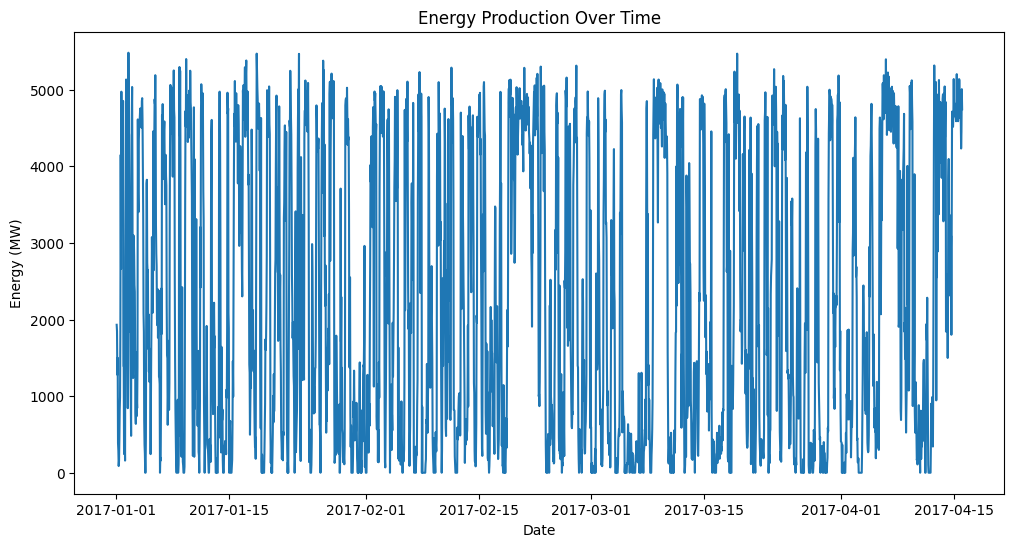

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['power_x'])
plt.title("Energy Production Over Time")
plt.xlabel("Date")
plt.ylabel("Energy (MW)")
plt.show()

In [8]:
import numpy as np

def create_features(df):
    # Extract time-based features
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    # Add lag and rolling features
    df['lag_1'] = df['power_x'].shift(1)
    df['lag_2'] = df['power_x'].shift(2)
    df['rolling_mean_3'] = df['power_x'].rolling(3).mean()
    # Drop rows with missing values in relevant columns
    df.dropna(subset=['power_x', 'lag_1', 'lag_2', 'rolling_mean_3'], inplace=True)
    return df

In [9]:
def create_targets(df, n_steps=6):
    # Create target columns for multi-step forecasting
    target_cols = [f'target_t+{i}' for i in range(1, n_steps + 1)]
    for i in range(1, n_steps + 1):
        df[f'target_t+{i}'] = df['power_x'].shift(-i)
    df.dropna(subset=target_cols, inplace=True)
    return df

In [10]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import joblib
import os

# Prepare features and targets
target_cols = [f'target_t+{i}' for i in range(1, 7)]
features = df.drop(columns=['date', 'power_x'] + target_cols)
targets = df[target_cols]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, shuffle=False)

# Train XGBoost models for each step
def train_models(X_train, y_train, X_test, y_test):
    models = []
    for i in range(6):
        model = xgb.XGBRegressor()
        model.fit(X_train, y_train.iloc[:, i])
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test.iloc[:, i], pred)
        print(f"Step {i+1} MAE: {mae:.2f}")
        models.append(model)
    return models

models = train_models(X_train, y_train, X_test, y_test)

# Save models
def save_models(models, path_prefix="models/xgb_model_t+"):
    os.makedirs(os.path.dirname(path_prefix), exist_ok=True)
    for i, model in enumerate(models):
        joblib.dump(model, f"{path_prefix}{i+1}.pkl")

save_models(models)

# Forecast function
def forecast_next_6_hours(latest_row, models):
    predictions = []
    for model in models:
        pred = model.predict(latest_row.values.reshape(1, -1))
        predictions.append(pred[0])
    return predictions

# Example forecast for the first test sample
true_vals = y_test.iloc[0]
pred_vals = forecast_next_6_hours(X_test.iloc[0], models)


KeyError: "['target_t+1', 'target_t+2', 'target_t+3', 'target_t+4', 'target_t+5', 'target_t+6'] not found in axis"

In [ ]:
import matplotlib.pyplot as plt

# Compare actual and predicted values for the first test sample
plt.plot(range(1, 7), true_vals, label='Actual')
plt.plot(range(1, 7), pred_vals, label='Predicted')
plt.xlabel("Hours Ahead")
plt.ylabel("Energy (MW)")
plt.legend()
plt.title("6-Hour Ahead Forecast")
plt.show()
